# Reanalysis preprocessing
***

__Author__: Chus Casado<br>
__Date__:   27-03-2022<br>

__Introduction__:<br>
This code extracts from the EFAS reanalysis data the discharge series in a selection of fixed reporting points.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

path_root = os.getcwd()

## 1 Configuration

In [2]:
# area threshold
area_threshold = 500

# return period
rp = 5

# start and end of the study period
start = '2020-10-14 12:00:00'
end = None

## 2 Stations

Load the table with all EFAS fixed reporting point and filter those points for which discharge data will be extracted.

In [3]:
# load table of fixed reporting points
stations = pd.read_csv('../data/Station-2022-10-27v12.csv', index_col='station_id')
# stations.index = stations.index.astype(str)
stations.index.name = 'id'
# filter stations and fields
mask = (stations['DrainingArea.km2.LDD'] >= area_threshold) & (stations.FixedRepPoint == True)
stations = stations.loc[mask, ['StationName', 'LisfloodX', 'LisfloodY', 'DrainingArea.km2.LDD', 'Catchment', 'River', 'EC_Catchments', 'Country code']]
stations.columns = stations.columns = ['name', 'X', 'Y', 'area', 'subcatchment', 'river', 'catchment', 'country']
stations[['strahler', 'pfafstetter']] = np.nan

In [4]:
# load shapefile with edited river and catchment names
points_edited = gpd.read_file('../data/GIS/fixed_report_points_500.shp')
points_edited.set_index('station_id', inplace=True, drop=True)
points_edited.index = points_edited.index.astype(int)
points_edited = points_edited[['StationNam', 'LisfloodX', 'LisfloodY', 'DrainingAr', 'Subcatchme',
                               'River', 'Catchment', 'Country co', 'strahler', 'pfafstette']]
points_edited.columns = stations.columns
# select points with a Pfafstetter code
mask = points_edited.pfafstetter.isnull()
points_edited = points_edited.loc[~mask]

In [5]:
# correct names of catchments and rivers
ids = list(set(stations.index).intersection(points_edited.index))
stations = stations.loc[ids]
for id in ids:
    for var in ['subcatchment', 'river', 'catchment']:
        if points_edited.loc[id, var] != np.nan:
            stations.loc[id, var] = points_edited.loc[id, var]

# add subcatchment and river order
stations.loc[ids, ['strahler', 'pfafstetter']] = points_edited.loc[ids, ['strahler', 'pfafstetter']]

# rename columns
#stations.columns = ['name', 'X', 'Y', 'area', 'subcatchment', 'river', 'catchment', 'country', 'strahler', 'subcatchment_order']

print('no. stations:\t{0}'.format(stations.shape[0]))

no. stations:	2371


In [6]:
# xarrys with station coordinates that will be used to extract data
x = xr.DataArray(stations.X, dims='id')
y = xr.DataArray(stations.Y, dims='id')

## 3 Discharge data

It loads the EFAS discharge reanalyses for the complete EFAS domain, and out of if only it extracts the discharge time series for the previously selected reporting points and the study period. The discharge timeseries are saved in a _parquet_ file.

In [7]:
var = 'discharge'

# output folder
out_path = f'../data/{var}/reanalysis/'
if os.path.exists(out_path) is False:
    os.makedirs(out_path)

# local directory where I have saved the raw data
path_reanalysis = 'E:/casadje/Documents/skill_assessment/data/CDS/reanalysis/'

# load dataset and extract variable discharge
files = glob.glob(f'{path_reanalysis}*202[0-3].nc')
dis = xr.open_mfdataset(files)['dis06']

# trim data to the study period
dis = dis.sel(time=slice(start, None))

# extract discharge for the selected stations
dis = dis.sel(x=x, y=y, method='nearest')
dis = dis.drop(['x', 'y', 'step', 'surface', 'latitude', 'longitude', 'valid_time'])

# compute the lazy DataArray
dis = dis.compute()

# add 6 h to the timesteps
dis['time'] = dis.time + np.timedelta64(6, 'h')

# save extraction as Parquet
dis_df = pd.DataFrame(dis.data, index=dis.time.data, columns=dis.id.data.astype(str))
dis_df.to_parquet(f'{out_path}EFAS_discharge_reanalysis.parquet')

**Check discharge timeseries**

To visually check the time series, we will plot the data for the Ebro catchment.

No. stations in the Rhine:	156


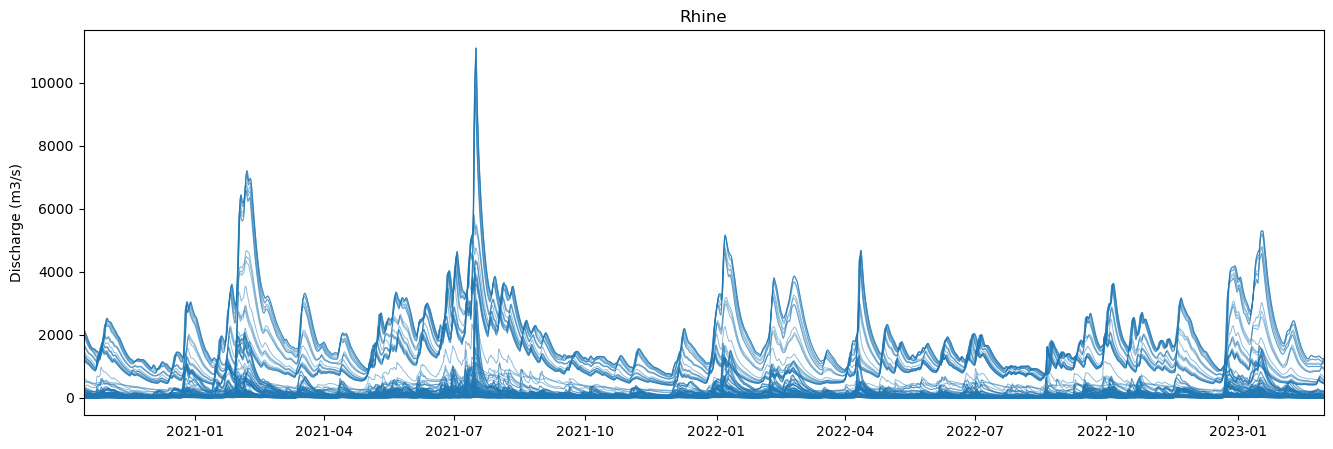

In [22]:
catchment = 'Rhine'

# filter stations in the catchment
stn_catchment = stations.loc[stations.catchment == catchment, :]
print(f'No. stations in the {catchment}:\t{stn_catchment.shape[0]}')

# plot discharge
plt.figure(figsize=(16, 5))
for stn in stn_catchment.index:
    plt.plot(dis.time, dis.sel(id=stn).data, lw=.7, c='C0', alpha=.5)
plt.title(catchment)
plt.xlim(dis.time[[0, -1]].data)
plt.ylabel('Discharge (m3/s)');

## 4 Exceedance

### 4.1 Discharge thresholds

The discharge thresholds are the discharge values for return periods 1.5, 2, 5, 10, 20, 50, 100, 200 and 500 years. The data is supplied in a NetCDF file that contains all the river network in Europe. This NetCDF is loaded as an _xarray_ and the values corresponding to the selected reporting points are extracted.

In [17]:
# load thresholds
path_thresholds = f'../data/thresholds/'
thresholds = xr.open_dataset(f'{path_thresholds}return_levels.nc')

# extract thresholds for the selected stations
thresholds = thresholds.sel(x=x, y=y, method='nearest')
thresholds = thresholds.drop(['x', 'y'])

In [18]:
# add thresholds to the DataFrame of stations
for var, da in thresholds.items():
    stations.loc[thresholds.id, var] = da.values.astype(int)

# export DataFrame of stations
stations.to_parquet(f'../results/reporting_points/reporting_points_over_{area_threshold}km2.parquet')

### 4.2 Exceedance over threshold

This block of code computes the exceedances of the 5-year return period out of the discharge timeseries and thresholds that were previously extracted. The results are seved in a _parquet_ file that will be used in the succeeding analys.

In [19]:
var = 'exceedance'

# output folder
out_path = f'../data/{var}/reanalysis/'
if os.path.exists(out_path) is False:
    os.makedirs(out_path)

# compute exceedance
thr = f'rl{rp}'
exc = dis >= thresholds[thr]

# # save as NetCDF
# exc.to_netcdf(f'{out_path}exceedance_rl{rp}.nc')
# save as Parquet
exc_df = pd.DataFrame(exc.data, index=exc.time.data, columns=exc.id.data.astype(str))
exc_df.to_parquet(f'{out_path}exceedance_rl{rp}.parquet')